# portfolio.py

In [1]:
import vectorbt as vbt
from vectorbt.utils import *

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
from datetime import datetime
index = pd.Index([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
])
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}, index=index).astype(float)

print(ts)

              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0


In [4]:
big_ts = pd.DataFrame(np.random.uniform(size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
entries = pd.DataFrame.vbt.signals.random(ts.shape, 2, every_nth=2, seed=42, index=ts.index, columns=ts.columns)
big_entries = pd.DataFrame.vbt.signals.random(big_ts.shape, 100, every_nth=2, seed=42, index=big_ts.index)

print(entries)

                a      b      c      d
2020-01-01  False  False  False   True
2020-01-02  False  False  False  False
2020-01-03   True  False   True  False
2020-01-04  False  False  False  False
2020-01-05   True   True  False  False
2020-01-06  False  False  False  False
2020-01-07  False   True   True   True


In [6]:
exits = entries.vbt.signals.random_exits(1, seed=42)
big_exits = big_entries.vbt.signals.random_exits(1, seed=42)

print(exits)

                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False  False  False
2020-01-03  False  False  False  False
2020-01-04   True  False   True   True
2020-01-05  False  False  False  False
2020-01-06   True   True  False  False
2020-01-07  False  False  False  False


## from_signals

In [7]:
vbt.portfolio.portfolio_defaults['investment'] = 100 # set investment in cash globally

In [8]:
portfolio = vbt.Portfolio.from_signals(ts['a'], entries['a'], exits['a'], volume=1)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0], volume=1)
print(vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0], volume=1).equity.shape)

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04   -1.0
2020-01-05    1.0
2020-01-06   -1.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02    100.0
2020-01-03     97.0
2020-01-04    101.0
2020-01-05     96.0
2020-01-06    102.0
2020-01-07    102.0
Name: a, dtype: float64
9.54 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
(1000,)


In [9]:
portfolio = vbt.Portfolio.from_signals(ts['a'], entries, exits, volume=1) # test broadcasting
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries, big_exits, volume=1)
print(vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries, big_exits, volume=1).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  0.0  1.0  0.0
2020-01-04 -1.0  0.0 -1.0 -1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06 -1.0 -1.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  1.0
2020-01-03  1.0  0.0  1.0  1.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
                a      b      c      d
2020-01-01  100.0  100.0  100.0   99.0
2020-01-02  100.0  100.0  100.0   99.0
2020-01-03   97.0  100.0   97.0   99.0
2020-01-04  101.0  100.0  101.0  103.0
2020-01-05   96.0   95.0  101.0  103.0
2020-01-06  102.0  101.0  101.0  103.0
2020-01-07  102.0   94.0   94.0   96.0
121 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [10]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=1)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  0.0  1.0  0.0
2020-01-04 -1.0  0.0 -1.0 -1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06 -1.0 -1.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  1.0
2020-01-03  1.0  0.0  1.0  1.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
                a      b      c     d
2020-01-01  100.0  100.0  100.0  96.0
2020-01-02  100.0  100.0  100.0  96.0
2020-01-03   97.0  100.0   97.0  96.0
2020-01-04  101.0  100.0  101.0  97.0
2020-01-05   96.0   95.0  101.0  97.0
2020-01-06  102.0   99.0  101.0  97.0
2020-01-07  102.0   96.0  100.0  93.0
109 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [11]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=np.inf) # all in/out
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=np.inf)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=np.inf).equity.shape)

                    a          b           c      d
2020-01-01   0.000000   0.000000    0.000000  25.00
2020-01-02   0.000000   0.000000    0.000000   0.00
2020-01-03  33.333333   0.000000   33.333333   0.00
2020-01-04 -33.333333   0.000000  -33.333333 -25.00
2020-01-05  26.666667  20.000000    0.000000   0.00
2020-01-06 -26.666667 -20.000000    0.000000   0.00
2020-01-07   0.000000  26.666667  133.333333   6.25
                    a          b           c      d
2020-01-01   0.000000   0.000000    0.000000  25.00
2020-01-02   0.000000   0.000000    0.000000  25.00
2020-01-03  33.333333   0.000000   33.333333  25.00
2020-01-04   0.000000   0.000000    0.000000   0.00
2020-01-05  26.666667  20.000000    0.000000   0.00
2020-01-06   0.000000   0.000000    0.000000   0.00
2020-01-07   0.000000  26.666667  133.333333   6.25
                     a      b           c     d
2020-01-01  100.000000  100.0  100.000000   0.0
2020-01-02  100.000000  100.0  100.000000   0.0
2020-01-03    0.000000  

In [12]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=1, commission=0.01) # w/ commission
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, commission=0.01)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, commission=0.01).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  0.0  1.0  0.0
2020-01-04 -1.0  0.0 -1.0 -1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06 -1.0 -1.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  1.0
2020-01-03  1.0  0.0  1.0  1.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
                     a           b           c          d
2020-01-01  100.000000  100.000000  100.000000  95.959596
2020-01-02  100.000000  100.000000  100.000000  95.959596
2020-01-03   96.969697  100.000000   96.969697  95.959596
2020-01-04  100.929697  100.000000  100.929697  96.949596
2020-01-05   95.879192   94.949495  100.929697  96.949596
2020-01-06  101.819192   98.909495  100.929697  96.949596
2020-01-07  101.819192   95.879192   99.919596  92.909192
107 ms ± 7.76 ms per loop (mean ± std. d

In [13]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=1, slippage=0.01) # w/ slippage
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, slippage=0.01)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, slippage=0.01).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  0.0  1.0  0.0
2020-01-04 -1.0  0.0 -1.0 -1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06 -1.0 -1.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  1.0
2020-01-02  0.0  0.0  0.0  1.0
2020-01-03  1.0  0.0  1.0  1.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  1.0  1.0  1.0
                 a       b       c      d
2020-01-01  100.00  100.00  100.00  95.96
2020-01-02  100.00  100.00  100.00  95.96
2020-01-03   96.97  100.00   96.97  95.96
2020-01-04  100.93  100.00  100.93  96.95
2020-01-05   95.88   94.95  100.93  96.95
2020-01-06  101.82   98.91  100.93  96.95
2020-01-07  101.82   95.88   99.92  92.91
104 ms ± 6.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [14]:
portfolio = vbt.Portfolio.from_signals(ts, 
                                 pd.DataFrame.vbt.signals.empty_like(ts, fill_value=True), 
                                 pd.DataFrame.vbt.signals.empty_like(ts, fill_value=False), 
                                 volume=1,
                                 accumulate=True) # w/ order accumulation
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit (vbt.Portfolio.from_signals(big_ts, \
                                 pd.DataFrame.vbt.signals.empty_like(big_ts, fill_value=True), \
                                 pd.DataFrame.vbt.signals.empty_like(big_ts, fill_value=False), \
                                 volume=1, \
                                 accumulate=True))
print((vbt.Portfolio.from_signals(big_ts, \
                                 pd.DataFrame.vbt.signals.empty_like(big_ts, fill_value=True), \
                                 pd.DataFrame.vbt.signals.empty_like(big_ts, fill_value=False), \
                                 volume=1, \
                                 accumulate=True).equity.shape))

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  97.0  83.0  97.0  93.0
2020-01-03  94.0  76.0  94.0  91.0
2020-01-04  90.0  70.0  90.0  90.0
2020-01-05  85.0  65.0  87.0  88.0
2020-01-06  79.0  61.0  85.0  85.0
2020-01-07  72.0  58.0  84.0  81.0
110 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


## from_orders

In [15]:
volume = pd.DataFrame.vbt.timeseries.empty_like(ts, 1) # buy 1 share every day
big_volume = pd.DataFrame.vbt.timeseries.empty_like(big_ts, 1)

In [16]:
portfolio = vbt.Portfolio.from_orders(ts['a'], volume['a'])
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_ts.iloc[:, 0], big_volume.iloc[:, 0])
print(vbt.Portfolio.from_orders(big_ts.iloc[:, 0], big_volume.iloc[:, 0]).equity.shape)

2020-01-01    1.0
2020-01-02    1.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    1.0
Name: a, dtype: float64
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
2020-01-06    6.0
2020-01-07    7.0
Name: a, dtype: float64
2020-01-01    99.0
2020-01-02    97.0
2020-01-03    94.0
2020-01-04    90.0
2020-01-05    85.0
2020-01-06    79.0
2020-01-07    72.0
Name: a, dtype: float64
6.81 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(1000,)


In [17]:
portfolio = vbt.Portfolio.from_orders(ts['a'], volume)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_ts.iloc[:, 0], big_volume)
print(vbt.Portfolio.from_orders(big_ts.iloc[:, 0], big_volume).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  99.0  99.0  99.0
2020-01-02  97.0  97.0  97.0  97.0
2020-01-03  94.0  94.0  94.0  94.0
2020-01-04  90.0  90.0  90.0  90.0
2020-01-05  85.0  85.0  85.0  85.0
2020-01-06  79.0  79.0  79.0  79.0
2020-01-07  72.0  72.0  72.0  72.0
53.1 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [18]:
portfolio = vbt.Portfolio.from_orders(ts, volume)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_ts, big_volume)
print(vbt.Portfolio.from_orders(big_ts, big_volume).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  97.0  83.0  97.0  93.0
2020-01-03  94.0  76.0  94.0  91.0
2020-01-04  90.0  70.0  90.0  90.0
2020-01-05  85.0  65.0  87.0  88.0
2020-01-06  79.0  61.0  85.0  85.0
2020-01-07  72.0  58.0  84.0  81.0
40.6 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [19]:
portfolio = vbt.Portfolio.from_orders(ts, volume, is_target=True) # target amount of shares to hold
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_ts, big_volume, is_target=True)
print(vbt.Portfolio.from_orders(big_ts, big_volume, is_target=True).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  0.0  0.0  0.0  0.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  0.0  0.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  0.0  0.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  99.0  91.0  99.0  96.0
2020-01-03  99.0  91.0  99.0  96.0
2020-01-04  99.0  91.0  99.0  96.0
2020-01-05  99.0  91.0  99.0  96.0
2020-01-06  99.0  91.0  99.0  96.0
2020-01-07  99.0  91.0  99.0  96.0
28.8 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


## from_order_func

In [20]:
@njit
def orders_func_np(i, j, run_cash, run_shares):
    return -i if i % 2 == 0 else i

portfolio = vbt.Portfolio.from_order_func(ts['a'], orders_func_np)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_ts.iloc[:, 0], orders_func_np)
print(vbt.Portfolio.from_order_func(big_ts.iloc[:, 0], orders_func_np).equity.shape)

2020-01-01    0.0
2020-01-02    1.0
2020-01-03   -1.0
2020-01-04    3.0
2020-01-05   -3.0
2020-01-06    5.0
2020-01-07   -5.0
Name: a, dtype: float64
2020-01-01    0.0
2020-01-02    1.0
2020-01-03    0.0
2020-01-04    3.0
2020-01-05    0.0
2020-01-06    5.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02     98.0
2020-01-03    101.0
2020-01-04     89.0
2020-01-05    104.0
2020-01-06     74.0
2020-01-07    109.0
Name: a, dtype: float64
The slowest run took 6.72 times longer than the fastest. This could mean that an intermediate result is being cached.
4.96 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [21]:
portfolio = vbt.Portfolio.from_order_func(ts, orders_func_np)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_ts, orders_func_np)
print(vbt.Portfolio.from_order_func(big_ts, orders_func_np).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  0.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03 -1.0 -1.0 -1.0 -1.0
2020-01-04  3.0  3.0  3.0  3.0
2020-01-05 -3.0 -3.0 -3.0 -3.0
2020-01-06  5.0  5.0  5.0  5.0
2020-01-07 -5.0 -5.0 -5.0 -5.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  0.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  0.0  0.0  0.0  0.0
2020-01-04  3.0  3.0  3.0  3.0
2020-01-05  0.0  0.0  0.0  0.0
2020-01-06  5.0  5.0  5.0  5.0
2020-01-07  0.0  0.0  0.0  0.0
                a      b      c      d
2020-01-01  100.0  100.0  100.0  100.0
2020-01-02   98.0   92.0   98.0   97.0
2020-01-03  101.0   99.0  101.0   99.0
2020-01-04   89.0   81.0   89.0   96.0
2020-01-05  104.0   96.0   98.0  102.0
2020-01-06   74.0   76.0   88.0   87.0
2020-01-07  109.0   91.0   93.0  107.0
33.4 ms ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


## Indexing and magic methods

In [7]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits)
big_portfolio = vbt.Portfolio.from_signals(big_ts, big_entries, big_exits)

In [23]:
print(portfolio.iloc[:, 0].equity)

%timeit big_portfolio.ts.iloc[:, 0]
%timeit big_portfolio.iloc[:, 0].ts

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03    100.000000
2020-01-04    133.333333
2020-01-05    133.333333
2020-01-06    160.000000
2020-01-07    160.000000
Name: a, dtype: float64
112 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.69 ms ± 723 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
portfolio_a = vbt.Portfolio.from_signals(ts, entries, exits, investment=100, slippage=0.01, commission=0.01)
portfolio_b = vbt.Portfolio.from_signals(ts, exits, entries, investment=200, slippage=0.01, commission=0.01)

portfolio_ab = portfolio_a + portfolio_b

print(portfolio_ab.ts)
print(portfolio_ab.cash)
print(portfolio_ab.shares)
print(portfolio_ab.investment)
print(portfolio_ab.slippage)
print(portfolio_ab.commission)

              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0
                     a           b           c           d
2020-01-01  300.000000  300.000000  300.000000  200.000000
2020-01-02  300.000000  300.000000  300.000000  200.000000
2020-01-03  200.000000  300.000000  200.000000  200.000000
2020-01-04  128.092277  300.000000  128.092277   24.017302
2020-01-05  240.173020  200.000000  128.092277   24.017302
2020-01-06  147.668683   76.855366  128.092277   24.017302
2020-01-07  147.668683  144.103812   48.034604  768.553663
                    a          b           c           d
2020-01-01   0.000000   0.000000    0.000000   24.504950
2020-01-02   0.000000   0.000000    0.000000   24.504950
2020-01-03  32.673267   0.000000   32.673267   24.504950
2020-01-04  49.009901   0.000000   49.009901  196.03

## General properties

In [25]:
# NOTE: don't forget to remove @cached_property before running %timeit

print(portfolio['a'].cash)
print(portfolio.cash)

%timeit big_portfolio.cash

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03      0.000000
2020-01-04    133.333333
2020-01-05      0.000000
2020-01-06    160.000000
2020-01-07    160.000000
Name: a, dtype: float64
                     a      b           c     d
2020-01-01  100.000000  100.0  100.000000   0.0
2020-01-02  100.000000  100.0  100.000000   0.0
2020-01-03    0.000000  100.0    0.000000   0.0
2020-01-04  133.333333  100.0  133.333333  25.0
2020-01-05    0.000000    0.0  133.333333  25.0
2020-01-06  160.000000   80.0  133.333333  25.0
2020-01-07  160.000000    0.0    0.000000   0.0
91.6 ns ± 4.43 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [26]:
print(portfolio['a'].shares)
print(portfolio.shares)

%timeit big_portfolio.shares

2020-01-01     0.000000
2020-01-02     0.000000
2020-01-03    33.333333
2020-01-04     0.000000
2020-01-05    26.666667
2020-01-06     0.000000
2020-01-07     0.000000
Name: a, dtype: float64
                    a          b           c      d
2020-01-01   0.000000   0.000000    0.000000  25.00
2020-01-02   0.000000   0.000000    0.000000  25.00
2020-01-03  33.333333   0.000000   33.333333  25.00
2020-01-04   0.000000   0.000000    0.000000   0.00
2020-01-05  26.666667  20.000000    0.000000   0.00
2020-01-06   0.000000   0.000000    0.000000   0.00
2020-01-07   0.000000  26.666667  133.333333   6.25
93.5 ns ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [27]:
print(portfolio['a'].equity)
print(portfolio.equity)

%timeit big_portfolio.equity

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03    100.000000
2020-01-04    133.333333
2020-01-05    133.333333
2020-01-06    160.000000
2020-01-07    160.000000
Name: a, dtype: float64
                     a      b           c      d
2020-01-01  100.000000  100.0  100.000000  100.0
2020-01-02  100.000000  100.0  100.000000   75.0
2020-01-03  100.000000  100.0  100.000000   50.0
2020-01-04  133.333333  100.0  133.333333   25.0
2020-01-05  133.333333  100.0  133.333333   25.0
2020-01-06  160.000000   80.0  133.333333   25.0
2020-01-07  160.000000   80.0  133.333333   25.0
1.12 µs ± 53.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [28]:
print(portfolio['a'].equity_in_shares)
print(portfolio.equity_in_shares)

%timeit big_portfolio.equity_in_shares

2020-01-01    100.000000
2020-01-02     50.000000
2020-01-03     33.333333
2020-01-04     33.333333
2020-01-05     26.666667
2020-01-06     26.666667
2020-01-07     22.857143
Name: a, dtype: float64
                     a          b           c          d
2020-01-01  100.000000  11.111111  100.000000  25.000000
2020-01-02   50.000000  12.500000   50.000000  25.000000
2020-01-03   33.333333  14.285714   33.333333  25.000000
2020-01-04   33.333333  16.666667   33.333333  25.000000
2020-01-05   26.666667  20.000000   44.444444  12.500000
2020-01-06   26.666667  20.000000   66.666667   8.333333
2020-01-07   22.857143  26.666667  133.333333   6.250000
1.12 µs ± 36.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [29]:
print(portfolio['a'].returns)
print(portfolio.returns)

%timeit big_portfolio.equity.pct_change()
%timeit big_portfolio.returns # numba helps a lot

2020-01-01         NaN
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-04    0.333333
2020-01-05    0.000000
2020-01-06    0.200000
2020-01-07    0.000000
Name: a, dtype: float64
                   a    b         c         d
2020-01-01       NaN  NaN       NaN       NaN
2020-01-02  0.000000  0.0  0.000000 -0.250000
2020-01-03  0.000000  0.0  0.000000 -0.333333
2020-01-04  0.333333  0.0  0.333333 -0.500000
2020-01-05  0.000000  0.0  0.000000  0.000000
2020-01-06  0.200000 -0.2  0.000000  0.000000
2020-01-07  0.000000  0.0  0.000000  0.000000
463 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.03 µs ± 40 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [30]:
print(portfolio['a'].drawdown)
print(portfolio.drawdown)

%timeit big_portfolio.drawdown

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
Name: a, dtype: float64
              a    b    c     d
2020-01-01  0.0  0.0  0.0  0.00
2020-01-02  0.0  0.0  0.0  0.25
2020-01-03  0.0  0.0  0.0  0.50
2020-01-04  0.0  0.0  0.0  0.75
2020-01-05  0.0  0.0  0.0  0.75
2020-01-06  0.0  0.2  0.0  0.75
2020-01-07  0.0  0.2  0.0  0.75
1.06 µs ± 18.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [31]:
print(portfolio['a'].trades)
print(portfolio.trades)

%timeit big_portfolio.trades

2020-01-01     0.000000
2020-01-02     0.000000
2020-01-03    33.333333
2020-01-04   -33.333333
2020-01-05    26.666667
2020-01-06   -26.666667
2020-01-07     0.000000
Name: a, dtype: float64
                    a          b           c      d
2020-01-01   0.000000   0.000000    0.000000  25.00
2020-01-02   0.000000   0.000000    0.000000   0.00
2020-01-03  33.333333   0.000000   33.333333   0.00
2020-01-04 -33.333333   0.000000  -33.333333 -25.00
2020-01-05  26.666667  20.000000    0.000000   0.00
2020-01-06 -26.666667 -20.000000    0.000000   0.00
2020-01-07   0.000000  26.666667  133.333333   6.25
1.1 µs ± 33.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [32]:
print(portfolio['a'].position_profits)
print(portfolio.position_profits)

%timeit big_portfolio.position_profits

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    33.333333
2020-01-05          NaN
2020-01-06    26.666667
2020-01-07          NaN
Name: a, dtype: float64
                    a     b          c     d
2020-01-01        NaN   NaN        NaN   NaN
2020-01-02        NaN   NaN        NaN   NaN
2020-01-03        NaN   NaN        NaN   NaN
2020-01-04  33.333333   NaN  33.333333 -75.0
2020-01-05        NaN   NaN        NaN   NaN
2020-01-06  26.666667 -20.0        NaN   NaN
2020-01-07        NaN   0.0   0.000000   0.0
1.24 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [33]:
print(portfolio['a'].position_returns)
print(portfolio.position_returns)

%timeit big_portfolio.position_returns

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    0.333333
2020-01-05         NaN
2020-01-06    0.200000
2020-01-07         NaN
Name: a, dtype: float64
                   a    b         c     d
2020-01-01       NaN  NaN       NaN   NaN
2020-01-02       NaN  NaN       NaN   NaN
2020-01-03       NaN  NaN       NaN   NaN
2020-01-04  0.333333  NaN  0.333333 -0.75
2020-01-05       NaN  NaN       NaN   NaN
2020-01-06  0.200000 -0.2       NaN   NaN
2020-01-07       NaN  0.0  0.000000  0.00
1.35 µs ± 424 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [34]:
print(portfolio['a'].win_mask)
print(portfolio.win_mask)

%timeit big_portfolio.win_mask

2020-01-01    False
2020-01-02    False
2020-01-03    False
2020-01-04     True
2020-01-05    False
2020-01-06     True
2020-01-07    False
Name: a, dtype: bool
                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False  False  False
2020-01-03  False  False  False  False
2020-01-04   True  False   True  False
2020-01-05  False  False  False  False
2020-01-06   True  False  False  False
2020-01-07  False  False  False  False
1.07 µs ± 47.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [35]:
print(portfolio['a'].loss_mask)
print(portfolio.loss_mask)

%timeit big_portfolio.loss_mask

2020-01-01    False
2020-01-02    False
2020-01-03    False
2020-01-04    False
2020-01-05    False
2020-01-06    False
2020-01-07    False
Name: a, dtype: bool
                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False  False  False
2020-01-03  False  False  False  False
2020-01-04  False  False  False   True
2020-01-05  False  False  False  False
2020-01-06  False   True  False  False
2020-01-07  False  False  False  False
1.04 µs ± 47.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [36]:
print(portfolio['a'].position_mask)
print(portfolio.position_mask)

%timeit big_portfolio.position_mask

2020-01-01    False
2020-01-02    False
2020-01-03    False
2020-01-04     True
2020-01-05    False
2020-01-06     True
2020-01-07    False
Name: a, dtype: bool
                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False  False  False
2020-01-03  False  False  False  False
2020-01-04   True  False   True   True
2020-01-05  False  False  False  False
2020-01-06   True   True  False  False
2020-01-07  False   True   True   True
1.07 µs ± 22.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Performance metrics

In [37]:
print(portfolio['a'].sum_win)
print(portfolio.sum_win)

%timeit big_portfolio.sum_win

60.0
a    60.000000
b     0.000000
c    33.333333
d     0.000000
dtype: float64
1.05 µs ± 38 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [38]:
print(portfolio['a'].sum_loss)
print(portfolio.sum_loss)

%timeit big_portfolio.sum_loss

0.0
a     0.0
b    20.0
c     0.0
d    75.0
dtype: float64
1.07 µs ± 70.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [39]:
print(portfolio['a'].avg_win)
print(portfolio.avg_win)

%timeit big_portfolio.avg_win

30.0
a    30.000000
b     0.000000
c    33.333333
d     0.000000
dtype: float64
1.07 µs ± 39.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [40]:
print(portfolio['a'].avg_loss)
print(portfolio.avg_loss)

%timeit big_portfolio.avg_loss

0.0
a     0.0
b    20.0
c     0.0
d    75.0
dtype: float64
1.08 µs ± 42.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [41]:
print(portfolio['a'].win_rate)
print(portfolio.win_rate)

%timeit big_portfolio.win_rate

1.0
a    1.0
b    0.0
c    0.5
d    0.0
dtype: float64
1.06 µs ± 14.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [42]:
print(portfolio['a'].loss_rate)
print(portfolio.loss_rate)

%timeit big_portfolio.loss_rate

0.0
a    0.0
b    0.5
c    0.0
d    0.5
dtype: float64
1.07 µs ± 31.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [43]:
print(portfolio['a'].profit_factor)
print(portfolio.profit_factor)

%timeit big_portfolio.profit_factor

inf
a    inf
b    0.0
c    inf
d    0.0
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:480: RuntimeWarning:

divide by zero encountered in true_divide



1.05 µs ± 36.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [44]:
print(portfolio['a'].appt)
print(portfolio.appt)

%timeit big_portfolio.appt

30.0
a    30.000000
b   -10.000000
c    16.666667
d   -37.500000
dtype: float64
1 µs ± 60.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [45]:
print(portfolio['a'].total_profit)
print(portfolio.total_profit)

%timeit big_portfolio.total_profit

60.0
a    60.000000
b   -20.000000
c    33.333333
d   -75.000000
dtype: float64
1.1 µs ± 66.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [46]:
print(portfolio['a'].total_return)
print(portfolio.total_return)

%timeit big_portfolio.total_return

0.6
a    0.600000
b   -0.200000
c    0.333333
d   -0.750000
dtype: float64
1.06 µs ± 29.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [47]:
print(portfolio['a'].mdd)
print(portfolio.mdd)

%timeit big_portfolio.mdd

0.0
a    0.00
b    0.20
c    0.00
d    0.75
dtype: float64
1.09 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Plotting

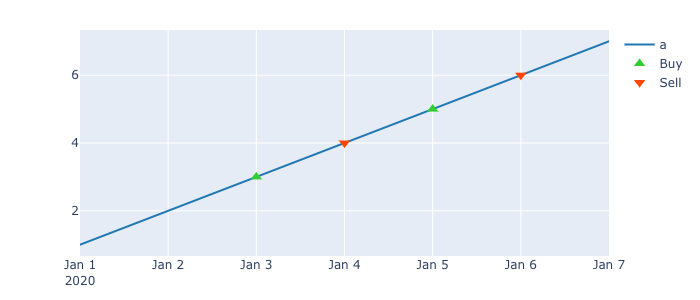

In [8]:
portfolio['a'].plot_trades().show_png()

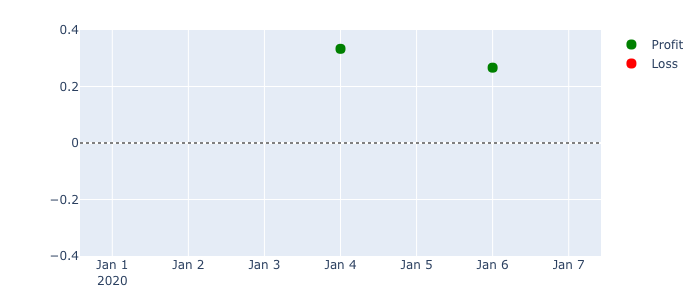

In [9]:
portfolio['a'].plot_position_profits().show_png()